In [1]:
#Source: 
#https://medium.com/@nikkisharma536/deep-learning-on-multi-label-text-classification-with-fastai-d5495d66ed88
#https://www.kaggle.com/nikkisharma536/fastai-toxic    

In [2]:
!pip install fastai

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!mkdir data models
!(cd data ; wget -cv https://ar51.s3.amazonaws.com/jigsaw-toxic-comment-classification-challenge.zip)
!(cd data ; unzip jigsaw-toxic-comment-classification-challenge.zip)

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘models’: File exists
--2019-11-18 05:18:16--  https://ar51.s3.amazonaws.com/jigsaw-toxic-comment-classification-challenge.zip
Resolving ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)... 52.216.176.83
Connecting to ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)|52.216.176.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55956017 (53M) [application/zip]
Saving to: ‘jigsaw-toxic-comment-classification-challenge.zip’

jigsaw-toxic-commen 100%[===================>]  53.36M  17.0MB/s    in 3.1s    

2019-11-18 05:18:20 (17.0 MB/s) - ‘jigsaw-toxic-comment-classification-challenge.zip’ saved [55956017/55956017]

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: test_labels.csv         
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
from fastai.text import *

In [8]:
train = pd.read_csv("./data/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train['comment_text'] = train['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [10]:
test = pd.read_csv("./data/test.csv")

test_id = test['id']
test['comment_text'] = test['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [11]:
data = (TextList.from_df(train, cols='comment_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,""" xxup -i think the references may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no - one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know . \n \n xxmaj there appears to be a backlog"
1,moved there with your own will xxbos xxmaj list of xxmaj royal xxmaj college xxmaj colombo alumni and xxmaj xxunk xxmaj xxunk and xxmaj cossde \n \n why this person xxmaj cossde does n't want to / trying to avoid / or shy to add the name of old royalist the no one cheater in sri xxunk to the list of xxmaj list of xxmaj royal xxmaj college xxmaj
2,"'d tell me to "" "" kick rocks . "" "" \n \n xxmaj as far as i 'm concerned , this is over . xxmaj move on . i am not addressing this any further , because nonsense like this keeps me from contributing and convinces me to leave xxmaj wikipedia again , and this time for good . xxmaj if xxmaj hell is other people , xxmaj"
3,"ease our worries by giving us an idea of what kinds of edits you 're planning to make ? - ( talk contribs ) "" xxbos xxmaj unfair xxmaj blocking \n \n i wanted to protest in no uncertain terms that you have been extremely unfair in blocking only me . xxmaj abhishek is equally guilty if not more guilty than me yet he gets away with a pep"
4,"( even if it is a red link ) . i sometimes delete hundereds of articles a day and unless you tell me what you are talking about and make it easy for me to find it , it is xxunk i will address your concerns . xxmaj thanks ! lk02 xxmaj chris xxmaj kreider \n \n "" xxbos "" \n \n xxmaj itaqallah and friends blatantly lying"


In [12]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


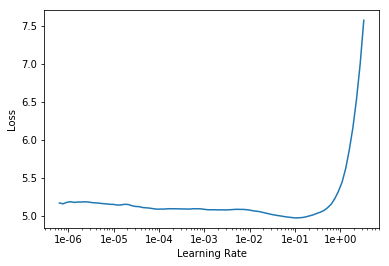

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.119742,3.871152,0.323048,06:31


In [16]:
learn.save_encoder('fine_tuned_enc')

In [17]:
label_cols = ['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']

In [18]:
test_datalist = TextList.from_df(test, cols='comment_text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='comment_text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
xxbos xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape \n xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup rape xxup anal xxup,toxic;severe_toxic;obscene
"xxbos "" \n i ca n't tell you any such thing . xxmaj what meets criterion a ) does n't meet b ) . xxmaj apparently no one else has anything to support the current ± language either . xxmaj walter xxmaj xxunk ( talk ) 2010 - 07 - 19 20:41 \n \n xxmaj there is another source for xxmaj tavernor on his derivation of "" """,
"xxbos "" i ca n't offer an offical document either , that the classical language category was introduced by a constitutional decree , but there are many notifications , that are not published on the internet , like the official notification , that xxmaj tamil was declared "" "" xxmaj classical language "" "" . xxmaj however , there are newspaper reports , which confirm , that the classical language",
"xxbos "" \n \n xxmaj you told me that i should n't write edits about general discussion on the talk pages of articles in xxmaj wikipedia . xxmaj but this time it was different . xxmaj whereas last time you were talking about the talk pages of articles , this time we are talking about the talk pages of users . xxmaj whereas article talk pages were general and",


In [19]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [20]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


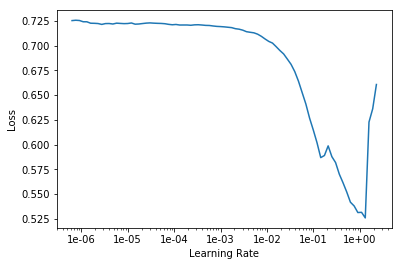

In [21]:
learn_classifier.recorder.plot()

In [22]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.083241,0.069931,02:57


In [23]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.062986,0.049721,03:29


In [24]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.045518,0.045255,05:29


In [25]:
learn_classifier.show_results()

text,target,prediction
"xxbos "" xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k xxrep 5 = xxup you ! f xxup uu c xxup kk xxup you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k xxrep 5 = xxup you ! f xxup uu c xxup kk xxup you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k xxrep 5 = xxup",toxic;severe_toxic;obscene;insult,toxic
xxbos xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
xxbos xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah xxup yaaa xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup,toxic;severe_toxic;obscene;insult,toxic;obscene;insult
xxbos xxup fuck xxup your xxup dog \n \n xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;threat;insult
"xxbos xxup lmao xxup what xxup weak xxup threats , i xxup havent xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup havent xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup havent xxup been xxup banned xxup yet xxup",toxic;severe_toxic;obscene;insult,toxic


In [26]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

In [27]:
labels

array([[9.899598e-01, 3.538900e-01, 9.628910e-01, 3.807180e-01, 8.857460e-01, 4.559312e-01],
       [4.176035e-03, 1.272026e-04, 1.399676e-03, 7.420364e-05, 7.706372e-04, 2.789749e-04],
       [1.130849e-02, 3.862307e-04, 3.752382e-03, 1.346585e-04, 2.226223e-03, 4.647063e-04],
       [2.013665e-04, 9.111643e-06, 7.590187e-05, 4.096269e-05, 5.093377e-05, 3.281198e-05],
       ...,
       [1.849000e-02, 2.496002e-04, 3.855662e-03, 8.896327e-05, 3.060475e-03, 4.945497e-04],
       [1.532508e-03, 1.761853e-05, 3.091959e-04, 9.219363e-06, 2.253280e-04, 5.664699e-05],
       [1.911786e-03, 2.061886e-05, 2.177607e-04, 1.318834e-05, 2.298115e-04, 2.024282e-04],
       [7.778826e-01, 7.406112e-03, 3.986827e-01, 1.163883e-03, 3.002997e-01, 3.654217e-03]], dtype=float32)

In [28]:
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission.csv', index=False)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.989960,0.353890,0.962891,0.380718,0.885746,0.455931
1,0000247867823ef7,0.004176,0.000127,0.001400,0.000074,0.000771,0.000279
2,00013b17ad220c46,0.011308,0.000386,0.003752,0.000135,0.002226,0.000465
3,00017563c3f7919a,0.000201,0.000009,0.000076,0.000041,0.000051,0.000033
4,00017695ad8997eb,0.003458,0.000062,0.000762,0.000197,0.000589,0.000154
